In [1]:
#Regression discontinuity
import pandas as pd
import numpy as np
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path_bank='/content/drive/MyDrive/Anitej/bank_data.csv'

In [5]:
df = pd.read_csv(path_bank)

In [6]:
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from scipy import stats
import statsmodels.api as sm


**Graphical exploratory data analysis**

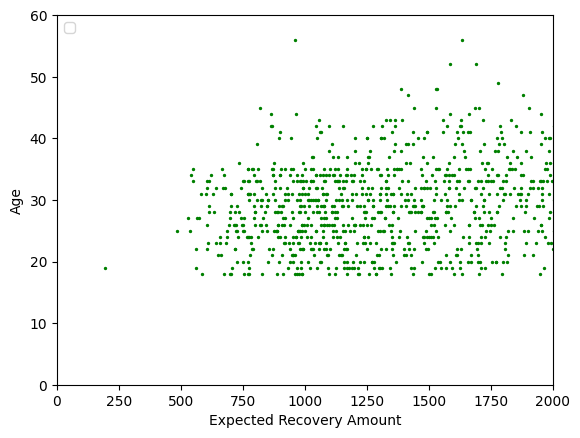

In [8]:
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)
plt.show()

**Statistical test: age vs. expected recovery amount**

In [10]:
# Compute average age just below and above the threshold
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()


       recovery_strategy
count  Level 0 Recovery     89.000000
       Level 1 Recovery     94.000000
mean   Level 0 Recovery     27.224719
       Level 1 Recovery     28.755319
std    Level 0 Recovery      6.399135
       Level 1 Recovery      5.859807
min    Level 0 Recovery     18.000000
       Level 1 Recovery     18.000000
25%    Level 0 Recovery     23.000000
       Level 1 Recovery     24.000000
50%    Level 0 Recovery     26.000000
       Level 1 Recovery     29.000000
75%    Level 0 Recovery     31.000000
       Level 1 Recovery     33.000000
max    Level 0 Recovery     56.000000
       Level 1 Recovery     43.000000
dtype: float64

In [11]:
# Perform Kruskal-Wallis test
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

**Statistical test: sex vs. expected recovery amount**

In [12]:
# Number of customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


**Exploratory graphical analysis: recovery amount**

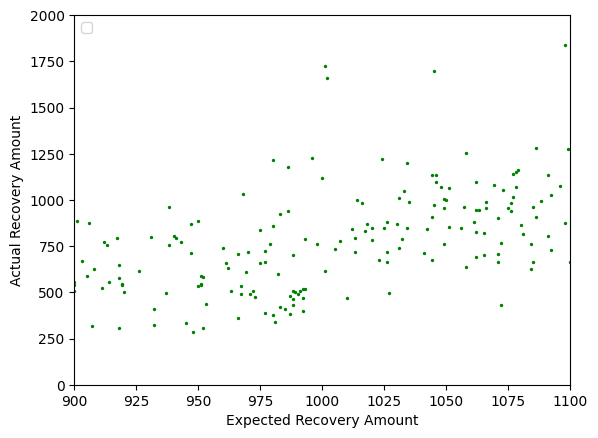

In [13]:
# Scatter plot of Actual Recovery Amount vs. Expected Recovery Amount
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)

**Statistical analysis: recovery amount**

In [14]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual)

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual)

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

**Regression modeling: no threshold**

In [17]:
# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            11:29:48   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression modeling: adding true threshold**

In [18]:
#Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount','indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            11:30:16   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Regression modeling: adjusting the window**

In [19]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]

# Define X and y
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            11:30:46   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278. This is much larger than the $50 per customer needed to run this higher recovery strategy